<a href="https://colab.research.google.com/github/marcexpositg/CRISPRed/blob/master/01.DescriptiveAnalysis/1.4.CoverageAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.4. Coverage Analysis

The final objective of this work is predicting the gene editing outcomes from the sequence of the edited region. For that, a library with a high number of variants is used, so most cells will not be edited in a target region. Hence, the sequencing coverage for the editing areas should be high enough to observe multiple gene editing outcomes for each target genomic region.

The objective of this section is determining the coverage of the target genomic regions.

Summary of the method:

- (1. Obtain coverage of all target regions) Target coordinates in `C3H_gRNA-coordinates.bed` are used to look at the genomic alignment files (`.bam`) to get the coverage (number of reads that align to a position in the genome) of each nucleotide in the target regions (the regions where gRNA aligins). This generates a pileup file for each sample.

- (2. Get mean coverage for each target region) Pileup files and the target coordinates are used to calculate the mean coverage of the nucleotides in each target region. The result is one CSV file per sample, indicating the mean coverage per target region.

- (3. Plot the results) The coverage per target region is represented to compare between samples.

## 1. Obtain coverage of all target regions

First, the coverage of each nucleotide belonging to a target region is determined.

For that, the aligned reads of the genomic sequencing samples are used (`.bam`, specified as `GenomicReads` variable), together with the fasta file of the reference genome C3H (`GCA_001632575.1_C3H_HeJ_v1.fa`), and the file produced in section 03 which indicates the coordinates of the target regions in the reference genome C3H (`C3H_gRNA-coordinates.bed`).

Since this files are large, and a specialized tool is used (`SAMtools mpileup`), the analyisis was run on a cluster, and files are not uploaded here. The analysis took nearly 30 minutes for each sample. Here, we show how this tool was used in the cluster.

The output of this process is a `.pileup` file containing the coverage for each nucleotide. An example of the output file is shown in the next section.

```
#!/bin/bash
#SBATCH -p normal 
#SBATCH -N 1
#SBATCH --ntasks-per-node=1
#SBATCH --mem-per-cpu 1000 
#SBATCH --time=10:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=###

#SBATCH -e stderr_filt_%j.err
#SBATCH -o stdout_filt_%j.out

### LOAD INITIAL MODULES ###
module load SAMtools/1.9-foss-2016b

### SAVE VARIABLES ###
GenomicReads=$1
OutFile=$2

### PIPELINE ###
samtools mpileup  -f ../Reference_Genomes/GCA_001632575.1_C3H_HeJ_v1.fa -l ./C3H_gRNA-coordinates.bed $GenomicReads -o $OutFile -a

#### Command:
#### execute inside /Coverage/ folder
#### sbatch pileup_gen_final.sh <genomicReads.bam> <outputFile.pileup>
```



Executed like that:



```
[mexposit@mr-login CoverageMarc]$ sbatch pileup_gen_final.sh ../Alignments_C3H/1-Cas9-pef-lib_C3H_aln.sorted.bam Cas9P_corr.pileup
[mexposit@mr-login CoverageMarc]$ sbatch pileup_gen_final.sh ../Alignments_C3H/2-Cas9-miss-lib_C3H_aln.sorte
d.bam Cas9M_corr.pileup
[mexposit@mr-login CoverageMarc]$ sbatch pileup_gen_final.sh ../Alignments_C3H/3-ABE-lib_C3H_aln.sorted.bam
ABE_corr.pileup
[mexposit@mr-login CoverageMarc]$ sbatch pileup_gen_final.sh ../Alignments_C3H/4-CBE-lib_C3H_aln.sorted.bam
CBE_corr.pileup
```



## 2. Get mean coverage for each target region

The previous step determined the coverage of each nucleotide in the target regions, and kept the result in a `.pileup` file. Since this files are relatively large, only one of them is loaded here, with name `Cas9P_sub.pileup`. There are three more files like that, each for the Cas9M, CBE and ABE samples.

Here, we show the header of this `pileup` file. Each line is a genomic position in the C3H genome. The first column indicates the chromosome number, the second the nucleotide position in the C3H genome, the third the nucleotide at this position, the fourth the reads (coverage) at this position. The fifth indicates the nucleotide of each read in that position (. is the same as in reference, and other simbols indicate a subsitution or deletion), and sixth the quality of the read at that positon. We will only use the information in the first four columns, as the fourth column indicates the coverage of each nucleotide.

In [1]:
# Import one pileup file as an example from Github
# The file is relatively large (50MB), so it takes a bit.
import requests
pileup_url = 'https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/01.DescriptiveAnalysis/GenomicCoverage/Cas9P_corr.pileup'
pileup_file = requests.get(pileup_url, allow_redirects=True)
open('Cas9P_corr.pileup', 'wb').write(pileup_file.content)

#from google.colab import drive
#drive.mount('/content/drive')
#%cd "drive/My Drive/CRISPred/01.DescriptiveAnalysis"

51504511

In [2]:
# first column indicates chromosome, second: genomic location, third: base identity, fourth: squencing reads that aligned in that region (coverage)
!head Cas9P_corr.pileup

chr1	14549564	G	607	..,,,...,.,,,.....,,.,........,..,,.....,..,,.,,,,,,,......,...,.,..,..,.,....,.,,,,.....,......,,..,,............,.........,............,,...,,............,,....................,......,,.........,...,,.....................,..,,,........,,,........,,.......,.....,,.............,,,,.....................,.......,,.........,..,..............................,.......$.....,....,,.,,,,,...,......,.....................,,......,.........................................,,..,.,................,...,.....................................,.............................,......................................^].^].^].^].^].^].^].^].^].	i8GGGC94GYGGGiOmkmGGNGNOiljONYGVZGGkmmmiGmm;CmGGGGGGGhmi]e5GNmmGBG^kGkfGOGUmm3GmGGGGY3ijkGmmimmmGGmkGG=lVkmmmc^[ci<ijmimRkmmGWGikmimmmb<mDGm[m>GhmmihmmRkGmmGGGmlmmiAmmmhmiji^iikmDmmmGGmGGmmGjmmkmCBlmmGGmGmmhkjmmGmmm:mmmPidmGekGGEGGjlhlmmGGGGmbmmimWGGmmmmmkmGGEGGm?:mmmGmmmmGlmmGGGGEGmmmkimmgkmmmmmmGm7m3GmGmimmYFG:km^@mlmdCmmGGciclimmmmQ@mmmmmmmmmGmGjml

The other required file is the file indicating the coordinates for each target region. This file is used to select only the nucleotides in each of the coordinate regions from the pileup file, and calculate the mean coverage per target region.

In [3]:
coords_file = requests.get('https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/01.DescriptiveAnalysis/GenomicCoverage/C3H_gRNA-coordinates.bed', allow_redirects=True)
open('C3H_gRNA-coordinates.bed', 'wb').write(coords_file.content)
!head C3H_gRNA-coordinates.bed

chr6	100230452	100230475	ENSMUSG00000033788_gR434r	0	+
chr6	100230783	100230806	ENSMUSG00000033788_gR113f	0	-
chr6	100230826	100230849	ENSMUSG00000033788_gR70f	0	-
chr15	100614257	100614280	ENSMUSG00000023020_gR346r	0	-
chr15	100614287	100614310	ENSMUSG00000023020_gR376r	0	-
chr15	100614345	100614368	ENSMUSG00000023020_gR434r	0	-
chr12	100701859	100701882	ENSMUSG00000021177_gR34f	0	+
chr12	100701959	100701982	ENSMUSG00000021177_gR124r	0	-
chr12	100702033	100702056	ENSMUSG00000021177_gR208f	0	+
chr13	100745175	100745198	ENSMUSG00000021645_gR59f	0	+


Since genomic samples are enriched target by target, there are differences between the coverage of different targets. Therefore, the distribution of the coverage of each target regions should be studied. 

Each line in the `pileup` file is a nucleotide in a target region, together with its coordinate and coverage value. Hence, the mean coverage for each target region has to be extracted as the mean coverage for each of the nucleotides in that region. For that, a Python script is used to store the coverage values of each target region. This script uses the `pileup` file of one sample together with the target regions coordinates in bed format. It does so in different steps:

- First, the script gets the information from the input files (as tab separated values) and converts it into a pandas data frame.

- Then, for each target region (there are 1785, one for each gRNA), searches the `pileup` file for all the nucleotides between the coordinates specified by the `bed` file with the coordinates. This are the nucleotides that form the target region. The script keeps their coverage value (number of reads of that genomic position) and calculates a mean from the coverage of all nucleotides belonging to one target region.

- Finally, the results are kept in a `csv` file, described below.

Note that the script naturally took the file names from the command line so that it could be reused for each of the four samples, and has been modified in Google Colabs to do it only with the example `pileup` file.

**Note: Executing the following script can take about 3-5 minutes.**

In [4]:
#!/usr/bin/env/ python
import sys
import numpy as np
import statistics
import pandas as pd

def df_from_tsv_file(data_file):
    """
    Opens a file with tab separated values (such as .bed file) and returns it as a pandas dataframe.
    The file should have no header.
    """
    df_file = pd.read_csv(data_file, sep="\t", header=None)
    return df_file


def mean_cov_per_gRNA(coordinates, pileup):
    """
    Gets genomic cordinates in bed format and searches its coverage in a database containing pileup.
    :param coordinates: genomic coordinates in BED format
    :param pileup: samtools mpileup output as a pandas dataframe
    :return: row of a dataframe with mean and SD of coverage for that target coordinates
    """
    gRNA_name = coordinates[3]
    chr = coordinates[0]
    start_coord = coordinates[1] + 1
    end_coord = coordinates[2]
    coverage_hist = []
    for position in range(start_coord, end_coord):
        site_pileup = pileup.loc[(pileup["chr"] == chr) & (pileup["chr_position"] == position)]
        try:
            site_coverage = int(site_pileup["coverage"])
            coverage_hist.append(site_coverage)
        except:
            site_coverage = np.nan

    try:
        coverage_mean = statistics.mean(coverage_hist)
        coverage_sd = statistics.stdev(coverage_hist)
    except:
        coverage_mean = np.nan
        coverage_sd = np.nan

    nrow = {'gRNA': gRNA_name, 'chr': chr, 'start_coord': start_coord, 'end_coord': end_coord,
            'coverage_mean': coverage_mean, 'coverage_sd': coverage_sd, 'coverage_hist': coverage_hist}
    return nrow


## get filename from command line arguments
#try:
#    coordinates_file_name = sys.argv[1]
#    pileup_file_name = sys.argv[2]
#    output_file_name = sys.argv[3]
#except IndexError:
#    raise SystemExit(f"Usage: Coverage_target.py <coordinates_file.bed> <pileup_file.pileup> <output_file_name.csv>")


coordinates_file_name = "C3H_gRNA-coordinates.bed"
pileup_file_name = "Cas9P_corr.pileup"
output_file_name = "Cas9P_coverage_example.csv"
# adapted for google colabs
#coordinates_file_name = "C3HCoordinates/C3Hcoord_sub_Seq.bed"
#pileup_file_name = "GenomicCoverage/Cas9P_sub.pileup"
#output_file_name = "GenomicCoverage/Cas9P_sub_coverage_example.csv"


# Imports the file containing the genomic coordinates of the target regions
Coordinates = df_from_tsv_file(coordinates_file_name)
# Imports a file containing the coverage of the nucleotides in the target regions
Pileup = df_from_tsv_file(pileup_file_name)
Pileup.columns = ["chr", "chr_position", "nucleotide", "coverage", "composition", "quality"]

# Initializes the output file as Data Frame
Coverage = pd.DataFrame(
    columns=['gRNA', 'chr', 'start_coord', 'end_coord', 'coverage_mean', 'coverage_sd', 'coverage_hist'])

# calculates the coverage of each target
for target_region in range(0, len(Coordinates)):
    new_row = mean_cov_per_gRNA(Coordinates.loc[target_region, :], Pileup)
    Coverage = Coverage.append(new_row, ignore_index=True)

# Exports to CSV format
Coverage.to_csv(output_file_name, index=False, na_rep='NULL')

The full analysis was done on the remote server, executing a slightly modified version of this script (to take the arguments) like that:

```
CoverageMarc]$ sbatch coverage_target.sh C3H_gRNA-coordinates.bed Cas9P_corr.pileup Cas9P_coverage_corr.csv
Submitted batch job 14866235
CoverageMarc]$ sbatch coverage_target.sh C3H_gRNA-coordinates.bed Cas9M_corr.pileup Cas9M_coverage_corr.csv
Submitted batch job 14866236
CoverageMarc]$ sbatch coverage_target.sh C3H_gRNA-coordinates.bed ABE_corr.pileup ABE_cov
erage_corr.csv
Submitted batch job 14866237
CoverageMarc]$ sbatch coverage_target.sh C3H_gRNA-coordinates.bed CBE_corr.pileup CBE_cov
erage_corr.csv
```

The content of `coverage_target.sh` is just a script that executes and passes command line arguments to the python `coverage_target.py` shown above.



```
#!/bin/bash
#SBATCH -p normal
#SBATCH -N 1
#SBATCH --ntasks-per-node=1
#SBATCH --mem-per-cpu 1000
#SBATCH --time=10:00:00
#SBATCH -e stderr_filt_%j.err
#SBATCH -o stdout_filt_%j.out
### LOAD INITIAL MODULES ###
module load Python/3.6.6-foss-2018b
### PIPELINE ###
python Coverage_target.py $*
#### Command:
#### sbatch coverage_target.sh <coordinates_file.bed> <pileup_file.pileup> <output_file_name.csv>
```





The output of this script contains multiple columns in CSV format. The header of the example produced here is shown below. Each column indicates:

 - The target region sequence (all target regions are 50nt long)
 - The chromosome of the target region
 - The initial coordinate of that target region
 - The end coordinate of that target region
 - The mean coverage of the nucleotides in that target region
 - A list with the coverage of each nucleotide in the target region

In [5]:
!head Cas9P_coverage_example.csv

gRNA,chr,start_coord,end_coord,coverage_mean,coverage_sd,coverage_hist
ENSMUSG00000033788_gR434r,chr6,100230453,100230475,773.7272727272727,14.687804523876322,"[751, 756, 758, 762, 762, 746, 768, 772, 776, 764, 772, 772, 783, 792, 794, 799, 773, 783, 775, 788, 781, 795]"
ENSMUSG00000033788_gR113f,chr6,100230784,100230806,854.9090909090909,7.295850685796498,"[870, 872, 865, 863, 856, 853, 844, 851, 847, 859, 851, 849, 855, 853, 855, 859, 851, 852, 845, 854, 853, 851]"
ENSMUSG00000033788_gR70f,chr6,100230827,100230849,795.7272727272727,13.881065617739248,"[818, 817, 811, 817, 806, 810, 809, 806, 798, 791, 797, 794, 791, 781, 780, 776, 788, 783, 781, 779, 783, 790]"
ENSMUSG00000023020_gR346r,chr15,100614258,100614280,866.0,19.66141980049835,"[829, 839, 851, 849, 849, 848, 863, 860, 854, 853, 857, 854, 863, 883, 878, 877, 895, 892, 890, 887, 893, 888]"
ENSMUSG00000023020_gR376r,chr15,100614288,100614310,880.0,6.768273325562718,"[886, 886, 890, 888, 887, 885, 875, 870, 879, 876, 878, 875, 8

Since the script is executed once per sample, there are a total of 4 .csv files indicating the mean coverage per target region, one for each sample. Even if only the Cas9P example was shown above, the 4 files are used in the script below to represent the coverage distribution. The files used are inside the GenomicCoverage, and their names are:

- GenomicCoverage/ABE_coverage_corr.csv
- GenomicCoverage/Cas9M_coverage_corr.csv
- GenomicCoverage/Cas9P_coverage_corr.csv
- GenomicCoverage/CBE_coverage_corr.csv

## 3. Plot the coverage distribution for each sample

To get an idea of the coverage in the target regions, the distribution of coverage for each target region is plotted for each sample in a density curve.

For that, a simple python script is used. Here it is asapted to download the files generated by the script above from Github.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Coverage Mean Cas9P: 669.3691380665445
Coverage Mean Cas9M: 650.8541786743516
Coverage Mean ABE: 729.4672255698187
Coverage Mean CBE: 583.0390096934754


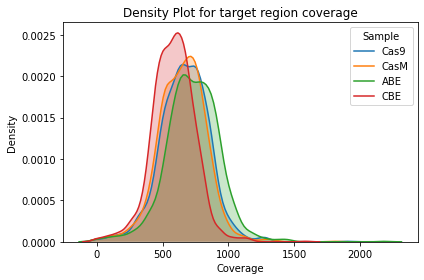

In [6]:
#!/usr/bin/env/ python
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

Cas9P_coverage = pd.read_csv("https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/01.DescriptiveAnalysis/GenomicCoverage/Cas9P_coverage_corr.csv", header=0)
Cas9M_coverage = pd.read_csv("https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/01.DescriptiveAnalysis/GenomicCoverage/Cas9M_coverage_corr.csv", header=0)
ABE_coverage = pd.read_csv("https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/01.DescriptiveAnalysis/GenomicCoverage/ABE_coverage_corr.csv", header=0)
CBE_coverage = pd.read_csv("https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/01.DescriptiveAnalysis/GenomicCoverage/CBE_coverage_corr.csv", header=0)

print("Coverage Mean Cas9P: " + str(np.nanmean(Cas9P_coverage['coverage_mean'])))
print("Coverage Mean Cas9M: " + str(np.nanmean(Cas9M_coverage['coverage_mean'])))
print("Coverage Mean ABE: " + str(np.mean(ABE_coverage['coverage_mean'])))
print("Coverage Mean CBE: " + str(np.mean(CBE_coverage['coverage_mean'])))

sns.kdeplot(Cas9P_coverage['coverage_mean'].dropna(), shade=True, label="Cas9")
sns.kdeplot(Cas9M_coverage['coverage_mean'].dropna(), shade=True, label="CasM")
sns.kdeplot(ABE_coverage['coverage_mean'].dropna(), shade=True, label="ABE")
sns.kdeplot(CBE_coverage['coverage_mean'].dropna(), shade=True, label="CBE")
plt.legend(title='Sample')
plt.title('Density Plot for target region coverage')  # add ,fontsize=
plt.xlabel('Coverage')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig("gRNAgenomicCoverage.png", dpi=600)
plt.show()
#plt.savefig('GenomicCoverage/TargetRegionsCoverage.png', dpi=300)
# this picture was downloaded and inserted in the thesis.

In [7]:
#from IPython.display import Image
#Image('GenomicCoverage/TargetRegionsCoverage.png',height=500)

**Conclusion:**

The results indicate a mean of 600 reads per target region in all samples. However, there are some target regions with few reads. This coverage is not sufficient to observe gene editing, explaining the absence of edition in the experiments.

## 4. Future steps

See if the coverage for a target region is correlated between samples, which would indicate deficiencies in the enrichment process.